In [1]:
# Core data analysis packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from scipy.sparse import csr_matrix 
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# import our files
user_artists = pd.read_csv('data/user_artists.dat',sep='\t')
artists = pd.read_csv('data/artists.dat',sep='\t',usecols=['id','name'])
tags = pd.read_csv('data/tags.dat', sep='\t',encoding='latin-1')
uta = pd.read_csv('data/user_taggedartists.dat', sep='\t')
utat = pd.read_csv('data/user_taggedartists-timestamps.dat', sep="\t")
friends = pd.read_csv('data/user_friends.dat', sep='\t')

## Step 2: Exploratory Data Analysis (EDA) and Preprocessing

In [3]:
num_users = user_artists['userID'].nunique()
num_artists = user_artists['artistID'].nunique()
print(f"Total users: {num_users}, Total artists: {num_artists}")

Total users: 1892, Total artists: 17632


In [14]:
#Create a binary version: 1 if a user has played the artist at least 1000 time. We will use this later to decide the commun neighbors.
user_artists['played'] = (user_artists['weight'] > 500).astype(int)

In [15]:
user_artists.weight.describe() # 75% of the users have played the artist less than 187 times. The max is 352698

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

## Step 3: Building the Graph Representation

In [16]:
B = nx.Graph()

users = user_artists['userID'].unique()
B.add_nodes_from(users, bipartite='users')

artist_ids = user_artists['artistID'].unique()
artist_nodes = [f"artist_{artist}" for artist in artist_ids]
B.add_nodes_from(artist_nodes, bipartite='artists')

edges = []
for row in user_artists.itertuples(index=False):
    if row.played == 1:
        user_id = row.userID
        artist_id = row.artistID
        # Append the edge only when played == 1
        edges.append((user_id, f"artist_{artist_id}", row.played))

B.add_weighted_edges_from(edges)

print("Total nodes in bipartite graph:", B.number_of_nodes())
print("Total edges in bipartite graph:", B.number_of_edges())


Total nodes in bipartite graph: 19524
Total edges in bipartite graph: 28127


## Step 3: Build the user-user graph

In [17]:
from networkx.algorithms import bipartite

# Project the bipartite graph onto the user nodes.
user_graph = bipartite.weighted_projected_graph(B, users)

print("Total nodes in user graph:", user_graph.number_of_nodes())
print("Unique users:", len(users)) # just to ensure what we are doing is correct

Total nodes in user graph: 1892
Unique users: 1892


In [18]:
print("Total nodes in user graph:", user_graph.number_of_nodes())
print("Total edges in user graph:", user_graph.number_of_edges())

Total nodes in user graph: 1892
Total edges in user graph: 298302


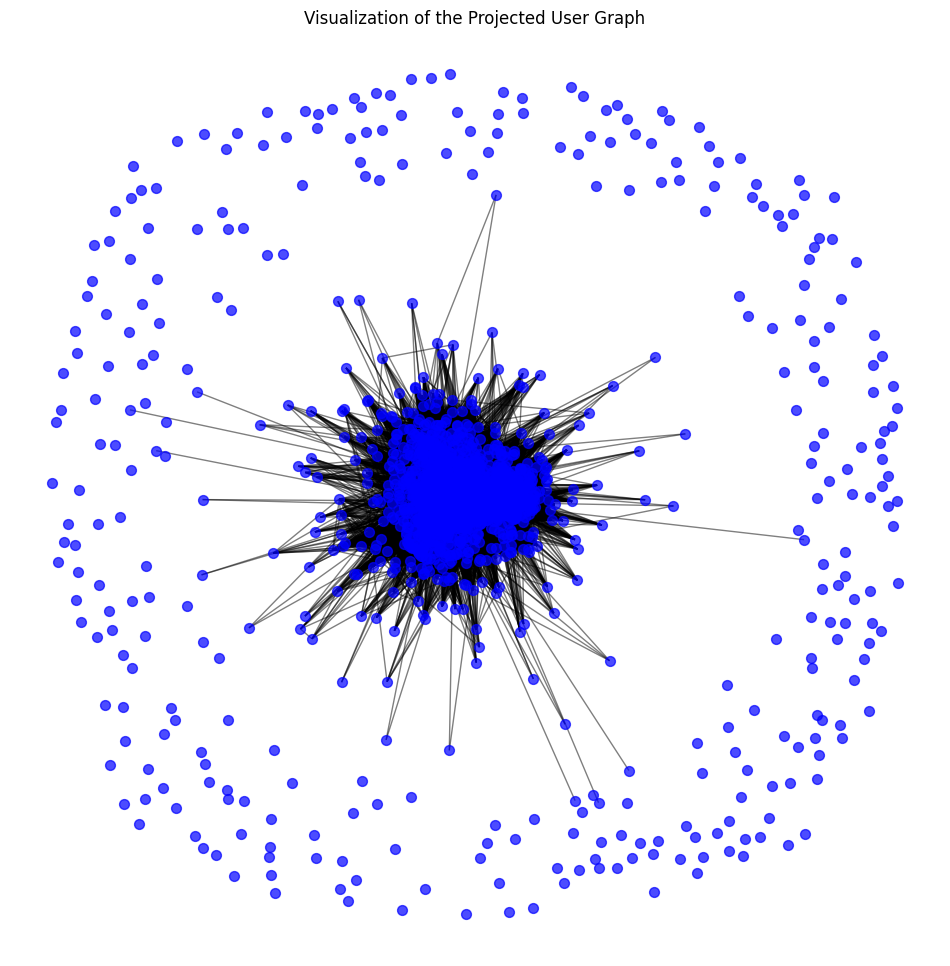

In [19]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(user_graph, k=0.1, iterations=20)
nx.draw_networkx_nodes(user_graph, pos, node_size=50, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(user_graph, pos, alpha=0.5)
plt.title("Visualization of the Projected User Graph")
plt.axis('off')
plt.show()

## Step 4: Graph-based similarity methods:

### Jaccard Coefficient

In [20]:
# Create candidate pairs (for all pairs where u < v)
candidate_pairs = [(u, v) for u in user_graph.nodes() for v in user_graph.nodes() if u < v]

# 1. Jaccard Coefficient
jaccard_scores = list(nx.jaccard_coefficient(user_graph, candidate_pairs))
print("Some Jaccard Coefficient scores:")
for u, v, coeff in jaccard_scores[:5]:
    print(f"Users ({u}, {v}) -> Jaccard: {coeff:.3f}")

Some Jaccard Coefficient scores:
Users (2, 3) -> Jaccard: 0.001
Users (2, 4) -> Jaccard: 0.367
Users (2, 5) -> Jaccard: 0.187
Users (2, 6) -> Jaccard: 0.000
Users (2, 7) -> Jaccard: 0.541


### Adamic–Adar Index

In [21]:
# 2. Adamic–Adar Index
adamic_adar_scores = list(nx.adamic_adar_index(user_graph, candidate_pairs))
print("\nSome Adamic–Adar scores:")
for u, v, aa_score in adamic_adar_scores[:5]:
    print(f"Users ({u}, {v}) -> Adamic–Adar: {aa_score:.3f}")


Some Adamic–Adar scores:
Users (2, 3) -> Adamic–Adar: 0.160
Users (2, 4) -> Adamic–Adar: 53.340
Users (2, 5) -> Adamic–Adar: 25.587
Users (2, 6) -> Adamic–Adar: 0.000
Users (2, 7) -> Adamic–Adar: 76.427


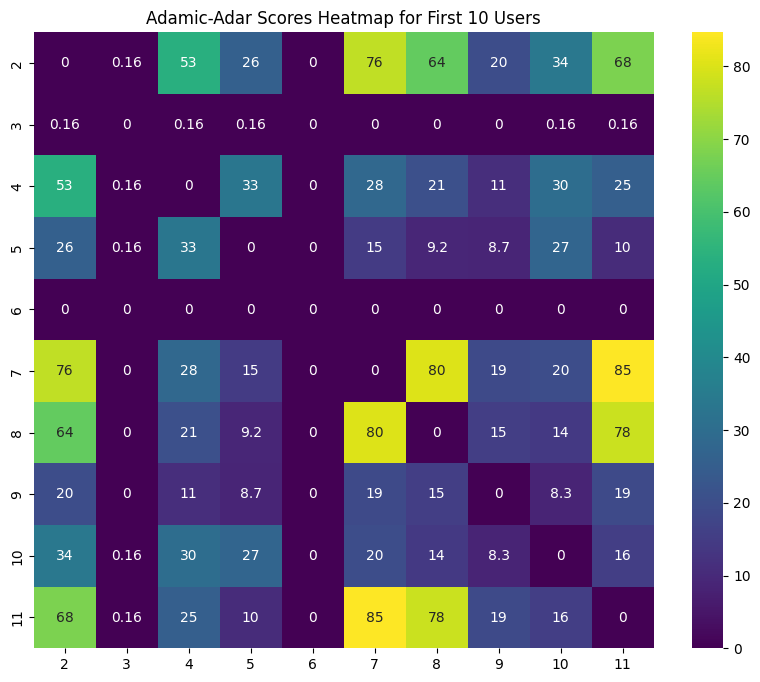

In [22]:
# Extract the first 10 users
first_10_users = users[:10]

# Create a matrix to store the Adamic-Adar scores
aa_matrix = np.zeros((10, 10))

# Fill the matrix with the Adamic-Adar scores
for u, v, aa_score in adamic_adar_scores:
    if u in first_10_users and v in first_10_users:
        i = np.where(first_10_users == u)[0][0]
        j = np.where(first_10_users == v)[0][0]
        aa_matrix[i, j] = aa_score
        aa_matrix[j, i] = aa_score  # Symmetric matrix

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(aa_matrix, xticklabels=first_10_users, yticklabels=first_10_users, cmap='viridis', annot=True)
plt.title("Adamic-Adar Scores Heatmap for First 10 Users")
plt.show()

### Common Neighbors

In [23]:
# 3. Common Neighbors for a specific pair:
def common_neighbors_score(u, v, G):
    """Return the number of common neighbors between u and v."""
    return len(list(nx.common_neighbors(G, u, v)))

u, v = 4, 2
if u in user_graph and v in user_graph:
    cn = common_neighbors_score(u, v, user_graph)
    print(f"\nCommon Neighbors between user {u} and user {v}: {cn}")
else:
    print("User 1 and/or User 2 not found in the graph.")


Common Neighbors between user 4 and user 2: 325


## Step 5: Thresholding the scores to decide music friends

### Music friends based on Adamic-Adar Index

In [24]:
scores = [score[2] for score in adamic_adar_scores]

scores_series = pd.Series(scores)
scores_series.median()  # we will consider the mean as a threshold to decide if two users are music friends or not


np.float64(3.684497026608529)

In [25]:
threshold = 100

# Filter pairs with Adamic-Adar score above the threshold
music_friends_adamic = [(u, v, score) for u, v, score in adamic_adar_scores if score > threshold]

print(f"Total music friends pairs with Adamic-Adar score above {threshold}: {len(music_friends_adamic)}")
for u, v, score in music_friends_adamic[:5]:
    print(f"Users ({u}, {v}) -> Adamic-Adar score: {score:.3f}")

Total music friends pairs with Adamic-Adar score above 100: 3476
Users (2, 159) -> Adamic-Adar score: 100.415
Users (2, 543) -> Adamic-Adar score: 103.559
Users (2, 592) -> Adamic-Adar score: 102.536
Users (2, 1255) -> Adamic-Adar score: 103.272
Users (2, 1280) -> Adamic-Adar score: 105.142


### Music friends based on Jaccard Coefficient

## Step 5: Evaluation metrics

In [ ]:
friendship_pairs = set((row.userID, row.friendID) for row in friends.itertuples(index=False))

ROC-AUC: 0.675
Average Precision: 0.013


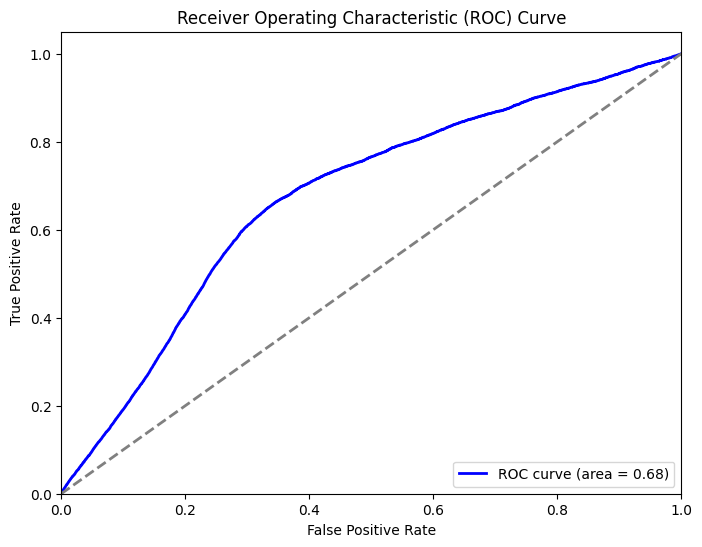

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve

# Compute the labels for the candidate pairs
labels = [1 if (u, v) in friendship_pairs or (v, u) in friendship_pairs else 0 for u, v in candidate_pairs]
scores = [score for _, _, score in adamic_adar_scores]
auc = roc_auc_score(labels, scores)
avg_precision = average_precision_score(labels, scores)
print(f"ROC-AUC: {auc:.3f}")
print(f"Average Precision: {avg_precision:.3f}") 
# Visualize the ROC curve

fpr, tpr, _ = roc_curve(labels, scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ROC-AUC: 0.744
Average Precision: 0.026


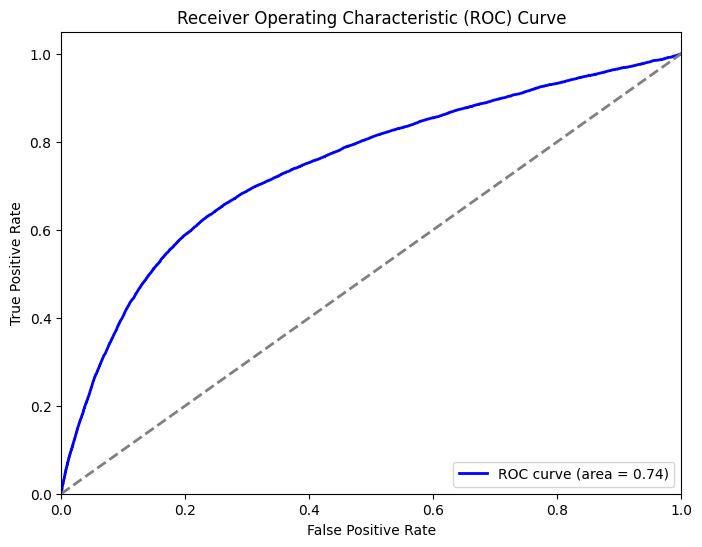

In [35]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve

# Compute the labels for the candidate pairs
labels = [1 if (u, v) in friendship_pairs or (v, u) in friendship_pairs else 0 for u, v in candidate_pairs]
scores = [score for _, _, score in jaccard_scores]
auc = roc_auc_score(labels, scores)
avg_precision = average_precision_score(labels, scores)
print(f"ROC-AUC: {auc:.3f}")
print(f"Average Precision: {avg_precision:.3f}") 
# Visualize the ROC curve

fpr, tpr, _ = roc_curve(labels, scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()